In [61]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from finta import TA
import pandas as pd
import plotly.graph_objects as go

class stock():
    def __init__(self,name):
        self.stock_df = pd.DataFrame(yf.Ticker(name).history(period="max"))
        self.stock_df.columns = map(str.lower, self.stock_df.columns)
        self.name = name
        
    def Bollinger_bands(self,start,end, upper = True, lower = True):
        self.stock_df.columns = map(str.lower, self.stock_df.columns)
        bbands = TA.BBANDS(self.stock_df)
        sns.set()
        if upper :
            bbands[start:end].BB_UPPER.plot()
        if lower :
            bbands[start:end].BB_LOWER.plot()
        self.stock_df["open"][start:end].rolling(window=7, center =True).mean().plot(label="MA 7 jours",ls = ":")
        plt.show()
        
    def cours(self):
    

        fig = go.Figure(data=go.Ohlc(x=self.stock_df.index,
            open=self.stock_df['open'],
            high=self.stock_df['high'],
            low=self.stock_df['low'],
            close=self.stock_df['close']))
        fig.show()
        
        

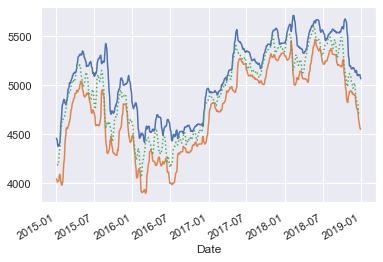

In [62]:
test = stock(name="^FCHI")
test.stock_df
test.Bollinger_bands("2015","2018")
test.cours()